# ResNet-34 Convolutional Neural Networks trained on CIFAR-10

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"currently available device: {device}")

currently available device: cuda


In [3]:
# Hyper-parameters-
num_epochs = 200
batch_size = 128
learning_rate = 0.001

In [4]:
# Define transformations for training and test sets-
transform_train = transforms.Compose(
    [
      transforms.RandomCrop(32, padding = 4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
     ]
     )

transform_test = transforms.Compose(
    [
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
     ]
     )

In [ ]:
'''
# Dataset has PILImage images of range [0, 1]. We transform them to Tensors
# of normalized range [-1, 1]
transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ]
        )
'''

In [ ]:
# os.chdir("/home/arjun/Documents/Programs/Python_Codes/PyTorch_Resources/Good_Codes/")

In [5]:
# Load dataset-
train_dataset = torchvision.datasets.CIFAR10(
        root = './data', train = True,
        download = True, transform = transform_train
        )

test_dataset = torchvision.datasets.CIFAR10(
        root = './data', train = False,
        download = True, transform = transform_test
        )


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
print(f"len(train_dataset) = {len(train_dataset)} & len(test_dataset) = {len(test_dataset)}")

len(train_dataset) = 50000 & len(test_dataset) = 10000


In [7]:
# Create training and testing loaders-
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size = batch_size,
        shuffle = True
        )

test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size = batch_size,
        shuffle = False
        )

In [8]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 391 & len(test_loader) = 79


In [9]:
# Sanity check-
len(train_dataset) / batch_size, len(test_dataset) / batch_size

(390.625, 78.125)

In [10]:
# Get some random training images-
# some_img = iter(train_loader)
# images, labels = some_img.next()
images, labels = next(iter(train_loader))

# You get 32 images due to our specified batch size-
print(f"images.shape: {images.shape} & labels.shape: {labels.shape}")

images.shape: torch.Size([128, 3, 32, 32]) & labels.shape: torch.Size([128])


In [11]:
class ResidualBlock(nn.Module):
    '''
    Residual Block within a ResNet CNN model
    '''
    def __init__(self, input_channels, num_channels, 
                 use_1x1_conv = False, strides = 1):
        # super(ResidualBlock, self).__init__()
        super().__init__()
     
        self.conv1 = nn.Conv2d(
            in_channels = input_channels, out_channels = num_channels,
            kernel_size = 3, padding = 1, stride = strides,
            bias = False
            )
        self.conv2 = nn.Conv2d(
            in_channels = num_channels, out_channels = num_channels,
            kernel_size = 3, padding = 1, stride = 1,
            bias = False
            )
        
        if use_1x1_conv:
            self.conv3 = nn.Conv2d(
                in_channels = input_channels, out_channels = num_channels,
                kernel_size = 1, stride = strides
                )
        else:
            self.conv3 = None
        
        self.bn1 = nn.BatchNorm2d(num_features = num_channels)
        self.bn2 = nn.BatchNorm2d(num_features = num_channels)
        self.relu = nn.ReLU(inplace = True)

        self.initialize_weights()
        
    
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        
        if self.conv3:
            X = self.conv3(X)
            # print(f"X.shape due to 1x1: {X.shape} & Y.shape = {Y.shape}")
        else:
            # print(f"X.shape without 1x1: {X.shape} & Y.shape = {Y.shape}")
            pass
        
        Y += X
        return F.relu(Y)
    
    
    def shape_computation(self, X):
        Y = self.conv1(X)
        print(f"self.conv1(X).shape: {Y.shape}")
        Y = self.conv2(Y)
        print(f"self.conv2(X).shape: {Y.shape}")
        
        if self.conv3:
            h = self.conv3(X)
            print(f"self.conv3(X).shape: {h.shape}")
    

    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight)

                '''
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                '''
            
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)


In [ ]:
'''
b1 = nn.Sequential(
    nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 7, stride = 2, padding = 3),
    nn.BatchNorm2d(num_features = 64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1))
'''

In [12]:
b0 = nn.Sequential(
    nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
    nn.BatchNorm2d(num_features = 64),
    nn.ReLU())
    # nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 1))
    # nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0))

In [13]:
# Sanity check-
b0(images).shape

torch.Size([128, 64, 32, 32])

In [14]:
def create_resnet_block(input_filters, output_filters, num_residuals, first_block = False):
    # Python list to hold the created ResNet blocks-
    resnet_blk = []
    
    for i in range(num_residuals):
        if i == 0 and first_block:
            resnet_blk.append(ResidualBlock(input_channels = input_filters, num_channels = output_filters, use_1x1_conv = True, strides = 2))
        else:
            resnet_blk.append(ResidualBlock(input_channels = output_filters, num_channels = output_filters, use_1x1_conv = False, strides = 1))
    
    return resnet_blk

In [15]:
b1 = nn.Sequential(*create_resnet_block(input_filters = 64, output_filters = 64, num_residuals = 3, first_block = True))

# Sanity check-
# b1(torch.normal(mean = 0.0, std = 1.0, size = (128, 64, 32, 32))).shape
# torch.Size([128, 64, 16, 16])

In [16]:
b2 = nn.Sequential(*create_resnet_block(input_filters = 64, output_filters = 128, num_residuals = 4, first_block = True))

# Sanity check-
# b2(torch.normal(mean = 0.0, std = 1.0, size = (128, 64, 16, 16))).shape
# torch.Size([128, 128, 8, 8])

In [17]:
b3 = nn.Sequential(*create_resnet_block(input_filters = 128, output_filters = 256, num_residuals = 6, first_block = True))

# b3(torch.normal(mean = 0.0, std = 1.0, size = (128, 128, 8, 8))).shape
# torch.Size([128, 256, 4, 4]) 

In [18]:
b4 = nn.Sequential(*create_resnet_block(input_filters = 256, output_filters = 512, num_residuals = 3, first_block = True))

# b4(torch.normal(mean = 0, std = 1, size = (128, 256, 4, 4))).shape
# torch.Size([128, 512, 2, 2])

In [ ]:
# m = nn.AdaptiveAvgPool2d(output_size = (1, 1))
# m(torch.normal(mean = 0, std = 1, size = (128, 512, 2, 2))).shape
# torch.Size([128, 512, 1, 1])

In [19]:
# Initialize ResNet-34 model-
model = nn.Sequential(
    b0, b1, b2, b3, b4,
    nn.AdaptiveAvgPool2d(output_size = (1, 1)),
    nn.Flatten(),
    nn.Linear(in_features = 512, out_features = 256),
    nn.Linear(in_features = 256, out_features = 10))

In [20]:
# Place model on GPU (if available)-
model.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [21]:
# Save random initial weights-
torch.save(model.state_dict(), '/content/ResNet-34_dense_layer_kaiming_normal_random_weights.pth')

In [ ]:
# model(images).shape
# torch.Size([128, 10])

In [22]:
# Sanity check- make predictions using the define model-
model(images.to(device)).shape  # don't forget to place images to GPU device

torch.Size([128, 10])

In [23]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

layer.shape = torch.Size([64, 3, 3, 3]) has 1728 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64, 64, 1, 1]) has 4096 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64, 64, 3, 3]) ha

In [24]:
print(f"Total number of parameters in ResNet-34 = {tot_params}")

Total number of parameters in ResNet-34 = 21414218


In [25]:
# Print layer names-
for layer in model.state_dict().keys():
    print(f"{layer} has dimension = {model.state_dict()[layer].shape}")

0.0.weight has dimension = torch.Size([64, 3, 3, 3])
0.0.bias has dimension = torch.Size([64])
0.1.weight has dimension = torch.Size([64])
0.1.bias has dimension = torch.Size([64])
0.1.running_mean has dimension = torch.Size([64])
0.1.running_var has dimension = torch.Size([64])
0.1.num_batches_tracked has dimension = torch.Size([])
1.0.conv1.weight has dimension = torch.Size([64, 64, 3, 3])
1.0.conv2.weight has dimension = torch.Size([64, 64, 3, 3])
1.0.conv3.weight has dimension = torch.Size([64, 64, 1, 1])
1.0.conv3.bias has dimension = torch.Size([64])
1.0.bn1.weight has dimension = torch.Size([64])
1.0.bn1.bias has dimension = torch.Size([64])
1.0.bn1.running_mean has dimension = torch.Size([64])
1.0.bn1.running_var has dimension = torch.Size([64])
1.0.bn1.num_batches_tracked has dimension = torch.Size([])
1.0.bn2.weight has dimension = torch.Size([64])
1.0.bn2.bias has dimension = torch.Size([64])
1.0.bn2.running_mean has dimension = torch.Size([64])
1.0.bn2.running_var has dimen

In [ ]:
X = images
X.shape

torch.Size([128, 3, 32, 32])

In [ ]:
X.to(device) # place on device

In [ ]:
'''
Before training ResNet-18, let us observe how the input shape changes across
different modules in ResNet.
As in all the previous architectures, the resolution decreases while the number
of channels increases up until the point where a global average pooling layer
aggregates all features.
'''
for layer in model:
    # X.to(device)
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([128, 64, 32, 32])
Sequential output shape:	 torch.Size([128, 64, 16, 16])
Sequential output shape:	 torch.Size([128, 128, 8, 8])
Sequential output shape:	 torch.Size([128, 256, 4, 4])
Sequential output shape:	 torch.Size([128, 512, 2, 2])
AdaptiveAvgPool2d output shape:	 torch.Size([128, 512, 1, 1])
Flatten output shape:	 torch.Size([128, 512])
Linear output shape:	 torch.Size([128, 256])
Linear output shape:	 torch.Size([128, 10])


In [ ]:
model(images.to(device)).shape

torch.Size([128, 10])

### Train ResNet-34 CNN model:

In [26]:
# User input parameters for Early Stopping in manual implementation-
minimum_delta = 0.001
patience = 3

In [27]:
# Initialize parameters for Early Stopping manual implementation-
best_val_loss = 100
loc_patience = 0

In [28]:
# Define loss function and optimizer-
loss = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 5e-4)

In [29]:
# Python3 lists to store model training metrics-
training_acc = []
validation_acc = []
training_loss = []
validation_loss = []

In [30]:
for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0.0
    running_loss_val = 0.0
    
    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break
    
    
    for batch, (images, labels) in enumerate(train_loader):
        # Attempt to push to GPU if available
        images = images.to(device)
        labels = labels.to(device)

        model.train()

        # Forward pass-
        outputs = model(images)

        # Compute loss-
        J = loss(outputs, labels)

        # Backward pass-
        optimizer.zero_grad()   # empty accumulated gradients

        J.backward()    # does backprop

        # Updates parameters-
        optimizer.step()
        
        # Compute model's performance statistics-
        running_loss += J.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        running_corrects += torch.sum(predicted == labels.data)

        '''
        # Print information every 100 steps-
        if (batch + 1) % 100 == 0:
            print(f"epoch {epoch + 1}/{num_epochs}, step {batch + 1}/{num_training_steps}, loss = {J.item():.4f}")
        '''

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    # print(f"\nepoch: {epoch + 1} training loss = {epoch_loss:.4f}, training accuracy = {epoch_acc * 100:.2f}%\n")

    total = 0
    correct = 0
    
    with torch.no_grad():
        for images, labels in test_loader:

            # Place features (images) and targets (labels) to GPU-
            images = images.to(device)
            labels = labels.to(device)
            # print(f"images.shape = {images.shape}, labels.shape = {labels.shape}")

            # Set model to evaluation mode-
            model.eval()
    
            # Make predictions using trained model-
            outputs = model(images)
            _, y_pred = torch.max(outputs, 1)

            # Compute validation loss-
            J_val = loss(outputs, labels)

            running_loss_val += J_val.item() * labels.size(0)
    
            # Total number of labels-
            total += labels.size(0)

            # Total number of correct predictions-
            correct += (y_pred == labels).sum()

    epoch_val_loss = running_loss_val / len(test_dataset)
    val_acc = 100 * (correct / total)
    print(f"\nepoch: {epoch + 1} training loss = {epoch_loss:.4f}, training accuracy = {epoch_acc * 100:.2f}%, val_loss = {epoch_val_loss:.4f} & val_accuracy = {val_acc:.2f}%\n")

    # Code for manual Early Stopping:
    if np.abs(epoch_val_loss < best_val_loss) >= minimum_delta:
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = epoch_val_loss
        
        # reset 'loc_patience' variable-
        loc_patience = 0
        
    else:  # there is no improvement in monitored metric 'val_loss'
        loc_patience += 1  # number of epochs without any improvement


    training_acc.append(epoch_acc * 100)
    validation_acc.append(val_acc)
    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)


epoch: 1 training loss = 1.6415, training accuracy = 39.09%, val_loss = 1.3673 & val_accuracy = 49.76%


epoch: 2 training loss = 1.2774, training accuracy = 53.48%, val_loss = 1.2395 & val_accuracy = 54.96%


epoch: 3 training loss = 1.0932, training accuracy = 60.75%, val_loss = 1.0207 & val_accuracy = 63.76%


epoch: 4 training loss = 0.9589, training accuracy = 65.87%, val_loss = 0.9532 & val_accuracy = 66.89%


epoch: 5 training loss = 0.8464, training accuracy = 69.86%, val_loss = 0.8976 & val_accuracy = 68.34%


epoch: 6 training loss = 0.7627, training accuracy = 73.09%, val_loss = 0.8464 & val_accuracy = 71.97%


epoch: 7 training loss = 0.7028, training accuracy = 75.42%, val_loss = 0.7621 & val_accuracy = 74.68%


epoch: 8 training loss = 0.6462, training accuracy = 77.39%, val_loss = 0.6776 & val_accuracy = 77.23%


epoch: 9 training loss = 0.6017, training accuracy = 79.17%, val_loss = 0.6349 & val_accuracy = 78.21%


epoch: 10 training loss = 0.5632, training accuracy = 

In [ ]:
print(f"\nResNet-34 CNN training on CIFAR-10 is complete\n")


ResNet-34 CNN training on CIFAR-10 is complete



In [31]:
# Variables for computing model metrics-
total = 0
correct = 0

In [32]:
# Evaluate trained CNN model. We don't want these operations to be tracked in
# the computational graph. Hence wrap these operations in-
with torch.no_grad():
    for images, labels in test_loader:

        # Place features (images) and targets (labels) to GPU-
        images = images.to(device)
        labels = labels.to(device)
        # print(f"images.shape = {images.shape}, labels.shape = {labels.shape}")

        # Set model to evaluation mode-
        model.eval()

        # Make predictions using trained model-
        outputs = model(images)
        _, y_pred = torch.max(outputs, 1)
    
        # Total number of labels-
        total += labels.size(0)

        # Total number of correct predictions-
        correct += (y_pred == labels).sum()

    val_acc = 100 * (correct / total)
    print(f"ResNet-34 trained CNN's validation metrics on CIFAR-10 are:")
    print(f"accuracy = {val_acc:.2f}%, # of correct labels = {correct} & total # of labels = {total}")


ResNet-34 trained CNN's validation metrics on CIFAR-10 are:
accuracy = 82.43%, # of correct labels = 8243 & total # of labels = 10000


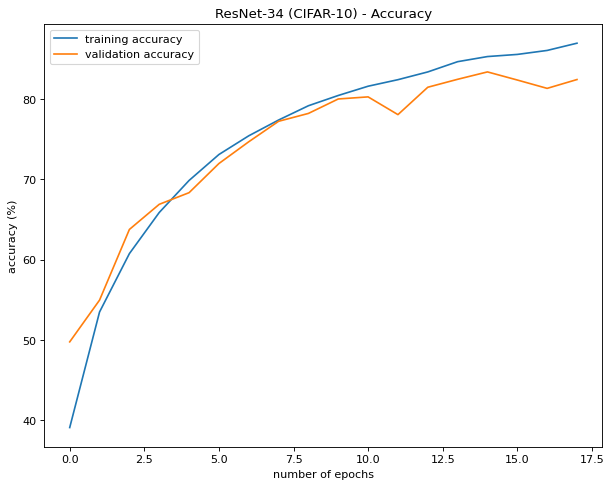

In [33]:
# Visualize training metrics-
fig=plt.figure(figsize=(9, 7), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(np.asarray(training_acc), label = 'training accuracy')
plt.plot(np.asarray(validation_acc), label = 'validation accuracy')

plt.title("ResNet-34 (CIFAR-10) - Accuracy")
plt.xlabel("number of epochs")
plt.ylabel("accuracy (%)")
# plt.xlim((0, 20))
plt.legend(loc = 'best')
plt.show()


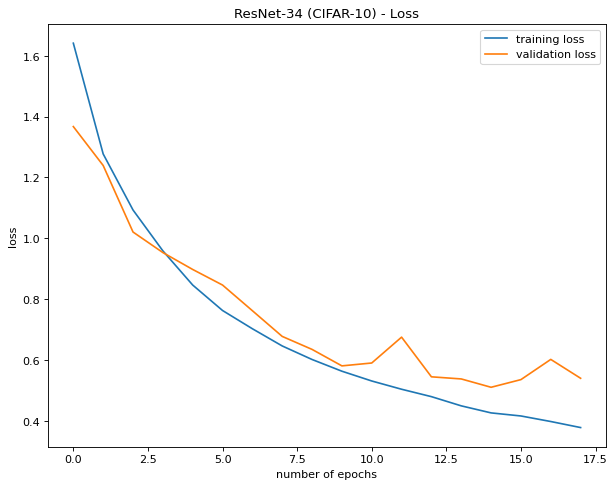

In [34]:
fig=plt.figure(figsize=(9, 7), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(np.asarray(training_loss), label = 'training loss')
plt.plot(np.asarray(validation_loss), label = 'validation loss')

plt.title("ResNet-34 (CIFAR-10) - Loss")
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.show()

**Save Trained model**

In [ ]:
os.getcwd()

'/content'

In [35]:
# Save trained ResNet model to HDD for later use-
torch.save(model.state_dict(), '/content/ResNet-34_dense_layer_kaiming_normal_trained.pth')

In [ ]:
# Initialize ResNet-34 model for testing trained model-

# Initialize ResNet-18 model for randomly initialized weights-
model_random = nn.Sequential(
    b1, b2, b3, b4, b5,
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(),
    nn.Linear(in_features = 512, out_features = 10))

In [ ]:
# Load random weights-
model_random.load_state_dict(torch.load('/content/ResNet-18_kaiming_normal_random_weights.pth'))

<All keys matched successfully>

In [ ]:
# Set model to evaluation mode-
model_random.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05

In [ ]:
# Place model on GPU-
model_random.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05

In [ ]:
total = 0.0
correct = 0.0

In [ ]:
# Evaluate trained CNN model. We don't want these operations to be tracked in
# the computational graph. Hence wrap these operations in-
with torch.no_grad():
    for images, labels in test_loader:

        # Place features (images) and targets (labels) to GPU-
        images = images.to(device)
        labels = labels.to(device)
        # print(f"images.shape = {images.shape}, labels.shape = {labels.shape}")

        # Set model to evaluation mode-
        # model_testing.eval()

        # Make predictions using trained model-
        outputs = model_random(images)
        _, y_pred = torch.max(outputs, 1)
    
        # Total number of labels-
        total += labels.size(0)

        # Total number of correct predictions-
        correct += (y_pred == labels).sum()

    val_acc = 100 * (correct / total)
    print(f"ResNet-22 randomly initialized CNN's validation metrics on CIFAR-10 are:")
    print(f"accuracy = {val_acc:.2f}%, # of correct labels = {correct} & total # of labels = {total}")


ResNet-19 randomly initialized CNN's validation metrics on CIFAR-10 are:
accuracy = 11.28%, # of correct labels = 1128.0 & total # of labels = 10000.0


In [ ]:
for layer in model.state_dict():
    print(f"layer = {layer} has dimensions: {model.state_dict()[layer].shape}")
    # print(layer)

layer = 0.0.weight has dimensions: torch.Size([64, 3, 7, 7])
layer = 0.0.bias has dimensions: torch.Size([64])
layer = 0.1.weight has dimensions: torch.Size([64])
layer = 0.1.bias has dimensions: torch.Size([64])
layer = 0.1.running_mean has dimensions: torch.Size([64])
layer = 0.1.running_var has dimensions: torch.Size([64])
layer = 0.1.num_batches_tracked has dimensions: torch.Size([])
layer = 1.0.conv1.weight has dimensions: torch.Size([64, 64, 3, 3])
layer = 1.0.conv2.weight has dimensions: torch.Size([64, 64, 3, 3])
layer = 1.0.bn1.weight has dimensions: torch.Size([64])
layer = 1.0.bn1.bias has dimensions: torch.Size([64])
layer = 1.0.bn1.running_mean has dimensions: torch.Size([64])
layer = 1.0.bn1.running_var has dimensions: torch.Size([64])
layer = 1.0.bn1.num_batches_tracked has dimensions: torch.Size([])
layer = 1.0.bn2.weight has dimensions: torch.Size([64])
layer = 1.0.bn2.bias has dimensions: torch.Size([64])
layer = 1.0.bn2.running_mean has dimensions: torch.Size([64])
l

In [ ]:
import seaborn as sns

In [ ]:
# Extract conv1 trained weights-
conv1_trained = model.state_dict()['0.0.weight'].cpu()

In [ ]:
# Extract conv1 random weights-
conv1_random = model_random.state_dict()['0.0.weight'].cpu()

In [ ]:
conv1_trained.shape, conv1_trained.flatten().shape

(torch.Size([64, 3, 7, 7]), torch.Size([9408]))

In [ ]:
conv1_random.shape, conv1_random.flatten().shape

(torch.Size([64, 3, 7, 7]), torch.Size([9408]))

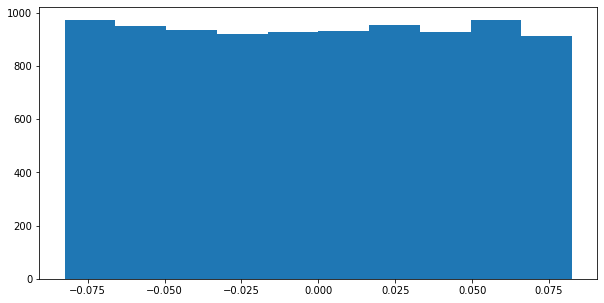

In [ ]:
plt.figure(figsize = (10, 5))
plt.hist(conv1_random.flatten(), label = 'kaiming normal random')
plt.show()

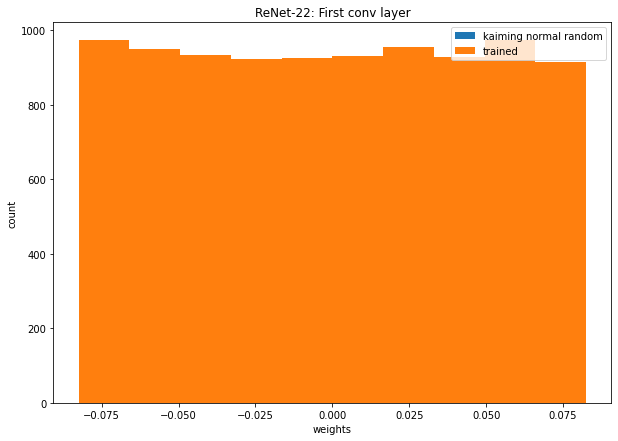

In [ ]:
plt.figure(figsize = (10, 7))

# sns.displot(data = conv1_random.flatten(), kde = True, label = 'kaiming normal random')
# sns.displot(data = conv1_trained.flatten(), kde = True, label = 'trained')

plt.hist(conv1_random.flatten(), label = 'kaiming normal random')
plt.hist(conv1_trained.flatten(), label = 'trained')

plt.xlabel("weights")
plt.ylabel("count")
plt.legend(loc = 'best')
plt.title("ReNet-22: First conv layer")
plt.show()

In [ ]:
# Load pre-trained model from before-
model_testing.load_state_dict(torch.load('/content/ResNet-19_trained.pth'))
model_testing.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05

In [ ]:
# Place model on GPU-
model_testing.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05

In [ ]:
# Variables for computing model metrics-
total = 0
correct = 0

In [ ]:
# Evaluate trained CNN model. We don't want these operations to be tracked in
# the computational graph. Hence wrap these operations in-
with torch.no_grad():
    for images, labels in test_loader:

        # Place features (images) and targets (labels) to GPU-
        images = images.to(device)
        labels = labels.to(device)
        # print(f"images.shape = {images.shape}, labels.shape = {labels.shape}")

        # Set model to evaluation mode-
        # model_testing.eval()

        # Make predictions using trained model-
        outputs = model_testing(images)
        _, y_pred = torch.max(outputs, 1)
    
        # Total number of labels-
        total += labels.size(0)

        # Total number of correct predictions-
        correct += (y_pred == labels).sum()

    val_acc = 100 * (correct / total)
    print(f"ResNet-19 trained CNN's validation metrics on CIFAR-10 are:")
    print(f"accuracy = {val_acc:.2f}%, # of correct labels = {correct} & total # of labels = {total}")


ResNet-19 trained CNN's validation metrics on CIFAR-10 are:
accuracy = 78.88%, # of correct labels = 7888 & total # of labels = 10000


In [ ]:
# Initialize ResNet-18 model for testing ENTIRE trained model-
model_testing_entire = nn.Sequential(
    b1, b2, b3, b4, b5,
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(),
    nn.Linear(in_features = 512, out_features = 10))



In [ ]:
# Load entire pre-trained model from before-
model_testing_entire = torch.load('/content/ResNet-19_trained_entire_model.pth')

In [ ]:
model_testing_entire.state_dict()

AttributeError: ignored

In [ ]:
# Set model to evaluation mode-
model_testing_entire.eval()

AttributeError: ignored